## 1. Import Libraries and Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import lightgbm as lgb

# Set random seed for reproducibility
np.random.seed(42)

# Visualization settings
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 2. Data Loading and Initial Preprocessing

In [2]:
def load_data():
    """Load all datasets with proper data types and date parsing"""
    print("Loading datasets...")
    
    # Load main datasets
    train_df = pd.read_csv('../data/raw/train.csv', parse_dates=['date'])
    test_df = pd.read_csv('../data/raw/test.csv', parse_dates=['date'])
    holiday_df = pd.read_csv('../data/raw/holidays_events.csv', parse_dates=['date'])
    oil_df = pd.read_csv('../data/raw/oil.csv', parse_dates=['date'])
    stores_df = pd.read_csv('../data/raw/stores.csv')
    transactions_df = pd.read_csv('../data/raw/transactions.csv', parse_dates=['date'])
    
    print(f"Train data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    print(f"Date range - Train: {train_df['date'].min()} to {train_df['date'].max()}")
    print(f"Date range - Test: {test_df['date'].min()} to {test_df['date'].max()}")
    
    return train_df, test_df, holiday_df, oil_df, stores_df, transactions_df

# Load data
train_df, test_df, holiday_df, oil_df, stores_df, transactions_df = load_data()

Loading datasets...
Train data shape: (3000888, 6)
Test data shape: (28512, 5)
Date range - Train: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Date range - Test: 2017-08-16 00:00:00 to 2017-08-31 00:00:00


## 3. Data Cleaning and Preprocessing

In [ ]:
def clean_data(train_df, test_df, oil_df, holiday_df, transactions_df):
    """Clean and preprocess all datasets"""
    print("Cleaning and preprocessing data...")
    
    # 1. Handle missing values in oil prices
    print(f"Missing oil prices: {oil_df['dcoilwtico'].isnull().sum()}")
    # interpolate missing oil pricees using polynomial interpolation
    oil_df['dcoilwtico_filled'] = oil_df['dcoilwtico'].interpolate(method='polynomial', order=2)    
    
    # 3. Create holiday indicators
    national_holidays = holiday_df[holiday_df['locale'] == 'National']['date'].unique()
    regional_holidays = holiday_df[holiday_df['locale'] == 'Regional']['date'].unique()
    local_holidays = holiday_df[holiday_df['locale'] == 'Local']['date'].unique()
    
    def add_holiday_features(df):
        df['is_national_holiday'] = df['date'].isin(national_holidays).astype(int)
        df['is_regional_holiday'] = df['date'].isin(regional_holidays).astype(int)
        df['is_local_holiday'] = df['date'].isin(local_holidays).astype(int)
        df['is_any_holiday'] = (df['is_national_holiday'] | df['is_regional_holiday'] | df['is_local_holiday']).astype(int)
        return df
    
    train_df = add_holiday_features(train_df)
    test_df = add_holiday_features(test_df)
    
    # 4. Handle earthquakes (specific events in Ecuador)
    earthquake_dates = holiday_df[holiday_df['description'].str.contains('Terremoto', case=False, na=False)]['date'].unique()
    train_df['is_earthquake'] = train_df['date'].isin(earthquake_dates).astype(int)
    test_df['is_earthquake'] = test_df['date'].isin(earthquake_dates).astype(int)
    
    print("Data cleaning completed.")
    return train_df, test_df, oil_df

# Clean data
train_df, test_df, oil_df = clean_data(train_df, test_df, oil_df, holiday_df, transactions_df)

Cleaning and preprocessing data...
Missing oil prices: 43
Negative sales records: 0 (0.00%)
Data cleaning completed.


## 4. Advanced Feature Engineering

In [ ]:
def create_temporal_features(df):
    """Create comprehensive temporal features"""
    # Basic temporal features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_year'] = df['date'].dt.dayofyear
    
    # Advanced temporal features
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    
    # ======= PAYROLL CYCLE FEATURES =======
    # Public sector wages paid on 15th and last day of month
    df['is_payday'] = ((df['day'] == 15) | df['date'].dt.is_month_end).astype(int)
    
    # Days since last payday
    def days_since_payday(date):
        day = date.day
        if day <= 15:
            # Days since last month's end
            last_month_end = date.replace(day=1) - timedelta(days=1)
            return (date - last_month_end).days
        else:
            # Days since 15th of current month
            current_month_15th = date.replace(day=15)
            return (date - current_month_15th).days
    
    df['days_since_payday'] = df['date'].apply(days_since_payday)
    
    # Days until next payday
    def days_until_payday(date):
        day = date.day
        if day < 15:
            # Days until 15th
            return 15 - day
        else:
            # Days until month end
            next_month = date.replace(day=28) + timedelta(days=4)
            month_end = next_month - timedelta(days=next_month.day)
            return (month_end - date).days
    
    df['days_until_payday'] = df['date'].apply(days_until_payday)
        
    # ======= EARTHQUAKE IMPACT FEATURES =======
    # Major earthquake on April 16, 2016
    earthquake_date = pd.to_datetime('2016-04-16')
    
    # Days since earthquake (for entire dataset)
    df['days_since_earthquake'] = (df['date'] - earthquake_date).dt.days
    
    # Post-earthquake impact periods
    df['is_earthquake_week'] = ((df['date'] >= earthquake_date) & 
                               (df['date'] <= earthquake_date + timedelta(days=7))).astype(int)
    
    df['is_earthquake_month'] = ((df['date'] >= earthquake_date) & 
                                (df['date'] <= earthquake_date + timedelta(days=30))).astype(int)
    
    df['is_earthquake_quarter'] = ((df['date'] >= earthquake_date) & 
                                  (df['date'] <= earthquake_date + timedelta(days=90))).astype(int)
    
    # Earthquake recovery phases
    # Week 1: Immediate impact (donations, relief efforts)
    df['earthquake_immediate'] = ((df['date'] >= earthquake_date) & 
                                 (df['date'] <= earthquake_date + timedelta(days=7))).astype(int)
    
    # Weeks 2-4: Recovery phase
    df['earthquake_recovery'] = ((df['date'] > earthquake_date + timedelta(days=7)) & 
                                (df['date'] <= earthquake_date + timedelta(days=30))).astype(int)
    
    # Months 2-3: Normalization phase
    df['earthquake_normalization'] = ((df['date'] > earthquake_date + timedelta(days=30)) & 
                                     (df['date'] <= earthquake_date + timedelta(days=90))).astype(int)
    
    # Earthquake intensity decay (exponential decay over time)
    df['earthquake_impact_decay'] = np.where(
        df['days_since_earthquake'] > 0,
        np.exp(-df['days_since_earthquake'] / 30),  # 30-day half-life
        0
    )
    
    # Cyclical encoding for temporal features
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # Payday cycle encoding (bi-monthly cycle)
    df['payday_cycle_sin'] = np.sin(2 * np.pi * df['days_since_payday'] / 15)
    df['payday_cycle_cos'] = np.cos(2 * np.pi * df['days_since_payday'] / 15)
    
    return df

def create_lag_features(df, target_col='sales', lags=[1, 7, 14, 30]):
    """Create lag features for time series"""
    df_sorted = df.sort_values(['store_nbr', 'family', 'date'])
    
    for lag in lags:
        df_sorted[f'{target_col}_lag_{lag}'] = df_sorted.groupby(['store_nbr', 'family'])[target_col].shift(lag)
    
    return df_sorted

def create_rolling_features(df, target_col='sales', windows=[7, 14, 30]):
    """Create rolling window statistics"""
    df_sorted = df.sort_values(['store_nbr', 'family', 'date'])
    
    for window in windows:
        # Rolling mean
        df_sorted[f'{target_col}_rolling_mean_{window}'] = df_sorted.groupby(['store_nbr', 'family'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        
        # Rolling std
        df_sorted[f'{target_col}_rolling_std_{window}'] = df_sorted.groupby(['store_nbr', 'family'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
        
        # Rolling max
        df_sorted[f'{target_col}_rolling_max_{window}'] = df_sorted.groupby(['store_nbr', 'family'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).max()
        )
        
        # Rolling min
        df_sorted[f'{target_col}_rolling_min_{window}'] = df_sorted.groupby(['store_nbr', 'family'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).min()
        )
    
    return df_sorted

def create_aggregated_features(df):
    """Create aggregated features across different dimensions"""
    # Store-level features
    store_features = df.groupby('store_nbr').agg({
        'sales': ['mean', 'std', 'sum'],
        'onpromotion': 'mean'
    }).round(3)
    store_features.columns = [f'store_{col[0]}_{col[1]}' for col in store_features.columns]
    store_features = store_features.reset_index()
    
    # Family-level features
    family_features = df.groupby('family').agg({
        'sales': ['mean', 'std', 'sum'],
        'onpromotion': 'mean'
    }).round(3)
    family_features.columns = [f'family_{col[0]}_{col[1]}' for col in family_features.columns]
    family_features = family_features.reset_index()
    
    # Store-Family interaction features
    store_family_features = df.groupby(['store_nbr', 'family']).agg({
        'sales': ['mean', 'std'],
        'onpromotion': 'mean'
    }).round(3)
    store_family_features.columns = [f'store_family_{col[0]}_{col[1]}' for col in store_family_features.columns]
    store_family_features = store_family_features.reset_index()
    
    return store_features, family_features, store_family_features

In [5]:
def engineer_features(train_df, test_df, oil_df, stores_df, transactions_df):
    """Apply all feature engineering steps"""
    print("Starting feature engineering...")
    
    # Combine train and test for consistent feature engineering
    test_df['sales'] = np.nan  # Add target column to test set
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    
    # 1. Temporal features
    print("Creating temporal features...")
    combined_df = create_temporal_features(combined_df)
    
    # 2. Merge with external data
    print("Merging external data...")
    # Merge oil prices
    combined_df = combined_df.merge(oil_df[['date', 'dcoilwtico_filled']], on='date', how='left')
    combined_df['dcoilwtico_filled'] = combined_df['dcoilwtico_filled'].fillna(method='ffill')
    
    # Merge store information
    combined_df = combined_df.merge(stores_df, on='store_nbr', how='left')
    
    # Merge transactions
    combined_df = combined_df.merge(transactions_df, on=['date', 'store_nbr'], how='left')
    
    # 3. Create aggregated features (only on training data)
    train_portion = combined_df[combined_df['sales'].notna()]
    store_features, family_features, store_family_features = create_aggregated_features(train_portion)
    
    # Merge aggregated features
    combined_df = combined_df.merge(store_features, on='store_nbr', how='left')
    combined_df = combined_df.merge(family_features, on='family', how='left')
    combined_df = combined_df.merge(store_family_features, on=['store_nbr', 'family'], how='left')
    
    # 4. Create interaction features
    print("Creating interaction features...")
    combined_df['promo_oil_interaction'] = combined_df['onpromotion'] * combined_df['dcoilwtico_filled']
    combined_df['weekend_promo'] = combined_df['is_weekend'] * combined_df['onpromotion']
    combined_df['holiday_promo'] = combined_df['is_any_holiday'] * combined_df['onpromotion']
    
    # ======= PAYROLL CYCLE INTERACTION FEATURES =======
    # Promotions during payday periods (should be highly effective)
    combined_df['payday_promo'] = combined_df['is_payday'] * combined_df['onpromotion']
    combined_df['near_payday_promo'] = combined_df['is_near_payday'] * combined_df['onpromotion']
    combined_df['pre_payday_promo'] = combined_df['is_pre_payday'] * combined_df['onpromotion']
    combined_df['post_payday_promo'] = combined_df['is_post_payday'] * combined_df['onpromotion']
    
    # Weekend shopping during payday periods
    combined_df['payday_weekend'] = combined_df['is_payday'] * combined_df['is_weekend']
    combined_df['near_payday_weekend'] = combined_df['is_near_payday'] * combined_df['is_weekend']
    
    # Oil price impact during payday (higher purchasing power)
    combined_df['payday_oil_interaction'] = combined_df['is_near_payday'] * combined_df['dcoilwtico_filled']
    
    # ======= EARTHQUAKE INTERACTION FEATURES =======
    # Promotion effectiveness during earthquake periods (likely reduced)
    combined_df['earthquake_promo_immediate'] = combined_df['earthquake_immediate'] * combined_df['onpromotion']
    combined_df['earthquake_promo_recovery'] = combined_df['earthquake_recovery'] * combined_df['onpromotion']
    combined_df['earthquake_promo_normalization'] = combined_df['earthquake_normalization'] * combined_df['onpromotion']
    
    # Oil price during earthquake (economic uncertainty)
    combined_df['earthquake_oil_immediate'] = combined_df['earthquake_immediate'] * combined_df['dcoilwtico_filled']
    combined_df['earthquake_oil_recovery'] = combined_df['earthquake_recovery'] * combined_df['dcoilwtico_filled']
    
    # Weekend shopping behavior during earthquake periods
    combined_df['earthquake_weekend_immediate'] = combined_df['earthquake_immediate'] * combined_df['is_weekend']
    combined_df['earthquake_weekend_recovery'] = combined_df['earthquake_recovery'] * combined_df['is_weekend']
    
    # Transaction volume impact during earthquake
    if 'transactions' in combined_df.columns:
        combined_df['earthquake_transactions_immediate'] = combined_df['earthquake_immediate'] * combined_df['transactions']
        combined_df['earthquake_transactions_recovery'] = combined_df['earthquake_recovery'] * combined_df['transactions']
    
    # Combined payroll and earthquake effects
    combined_df['payday_earthquake_conflict'] = combined_df['is_near_payday'] * combined_df['earthquake_impact_decay']
    
    # 5. Create product family specific payday effects
    print("Creating product family specific features...")
    # Define essential vs non-essential product categories
    essential_families = ['GROCERY I', 'BEVERAGES', 'CLEANING', 'DAIRY', 'BREAD/BAKERY', 
                         'MEATS', 'PRODUCE', 'FROZEN FOODS', 'PREPARED FOODS']
    
    combined_df['is_essential_family'] = combined_df['family'].isin(essential_families).astype(int)
    combined_df['is_non_essential_family'] = (~combined_df['family'].isin(essential_families)).astype(int)
    
    # Payday effects should be stronger for non-essential items
    combined_df['payday_essential'] = combined_df['is_payday'] * combined_df['is_essential_family']
    combined_df['payday_non_essential'] = combined_df['is_payday'] * combined_df['is_non_essential_family']
    combined_df['near_payday_non_essential'] = combined_df['is_near_payday'] * combined_df['is_non_essential_family']
    
    # Earthquake effects - essential items might see increased demand during crisis
    combined_df['earthquake_essential_immediate'] = combined_df['earthquake_immediate'] * combined_df['is_essential_family']
    combined_df['earthquake_non_essential_immediate'] = combined_df['earthquake_immediate'] * combined_df['is_non_essential_family']
    
    # 6. Create lag and rolling features (only for training portion to avoid data leakage)
    print("Creating lag and rolling features...")
    train_portion_with_lags = create_lag_features(train_portion)
    train_portion_with_lags = create_rolling_features(train_portion_with_lags)
    
    # For test set, use the last known values for lag features
    test_portion = combined_df[combined_df['sales'].isna()]
    # Simple approach: fill lag features with historical averages
    for col in train_portion_with_lags.columns:
        if 'lag_' in col or 'rolling_' in col:
            if col not in test_portion.columns:
                test_portion[col] = np.nan
    
    # Recombine with proper lag features for train
    final_train = train_portion_with_lags
    final_test = test_portion
    
    # 7. Encode categorical variables
    print("Encoding categorical variables...")
    categorical_columns = ['family', 'city', 'state', 'type']
    
    # Label encoding for categorical variables
    label_encoders = {}
    for col in categorical_columns:
        if col in final_train.columns:
            le = LabelEncoder()
            # Fit on combined data to ensure consistency
            all_values = pd.concat([final_train[col], final_test[col]]).astype(str)
            le.fit(all_values)
            final_train[f'{col}_encoded'] = le.transform(final_train[col].astype(str))
            final_test[f'{col}_encoded'] = le.transform(final_test[col].astype(str))
            label_encoders[col] = le
    
    print(f"Feature engineering completed. Train shape: {final_train.shape}, Test shape: {final_test.shape}")
    return final_train, final_test, label_encoders

# Apply feature engineering
train_engineered, test_engineered, label_encoders = engineer_features(
    train_df, test_df, oil_df, stores_df, transactions_df
)

Starting feature engineering...
Creating temporal features...
Merging external data...
Creating interaction features...
Creating product family specific features...
Creating lag and rolling features...
Encoding categorical variables...
Feature engineering completed. Train shape: (3000888, 72), Test shape: (28512, 110)


## 5. Feature Selection and Preparation

In [6]:
def prepare_features(train_df, test_df, target_col='sales'):
    """Prepare features for modeling"""
    print("Preparing features for modeling...")
    
    # Define feature columns to exclude
    exclude_columns = [
        'id', 'date', 'sales',  # Target and identifier columns
        'family', 'city', 'state', 'type',  # Original categorical (we have encoded versions)
    ]
    
    # Get feature columns
    feature_columns = [col for col in train_df.columns if col not in exclude_columns]
    
    # Remove columns with too many missing values
    missing_threshold = 0.5
    high_missing_cols = []
    for col in feature_columns:
        if train_df[col].isnull().mean() > missing_threshold:
            high_missing_cols.append(col)
    
    feature_columns = [col for col in feature_columns if col not in high_missing_cols]
    print(f"Removed {len(high_missing_cols)} columns with >50% missing values")
    
    # Prepare training data
    X_train = train_df[feature_columns].copy()
    y_train = train_df[target_col].copy()
    
    # Prepare test data
    X_test = test_df[feature_columns].copy()
    
    # Handle missing values
    print("Handling missing values...")
    # Fill missing values with median for numerical columns
    for col in X_train.columns:
        if X_train[col].dtype in ['float64', 'int64']:
            median_value = X_train[col].median()
            X_train[col].fillna(median_value, inplace=True)
            X_test[col].fillna(median_value, inplace=True)
    
    print(f"Final feature set: {len(feature_columns)} features")
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    return X_train, X_test, y_train, feature_columns

# Prepare features
X_train, X_test, y_train, feature_columns = prepare_features(train_engineered, test_engineered)

Preparing features for modeling...
Removed 0 columns with >50% missing values
Handling missing values...
Final feature set: 65 features
Training data shape: (3000888, 65)
Test data shape: (28512, 65)


## 6. Model Training and Evaluation

In [13]:
def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    # Ensure no negative predictions (log requires positive values)
    y_pred_clipped = np.maximum(y_pred, 0.01)  # Clip to small positive value
    y_true_clipped = np.maximum(y_true, 0.01)
    
    # Calculate RMSLE
    log_diff = np.log1p(y_pred_clipped) - np.log1p(y_true_clipped)
    return np.sqrt(np.mean(log_diff ** 2))

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance using RMSLE as primary metric"""
    # Competition metric: RMSLE
    rmsle_score = rmsle(y_true, y_pred)
    
    # Additional metrics for comparison
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"RMSLE (Competition Metric): {rmsle_score:.6f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {'model': model_name, 'rmsle': rmsle_score, 'rmse': rmse, 'mae': mae, 'r2': r2}

def rmsle_scorer(y_true, y_pred):
    """RMSLE scorer for sklearn GridSearchCV (returns negative for maximization)"""
    return -rmsle(y_true, y_pred)

def train_baseline_models(X_train, X_test, y_train, y_test):
    """Train baseline models"""
    print("Training baseline models...")
    results = []
    models = {}
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_lr, 'Linear Regression'))
    models['Linear Regression'] = lr
    
    # Ridge Regression
    ridge = Ridge(alpha=1.0, random_state=42)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_ridge, 'Ridge Regression'))
    models['Ridge Regression'] = ridge
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))
    models['Random Forest'] = rf
    
    return results, models

def train_advanced_models(X_train, X_test, y_train, y_test):
    """Train advanced models if libraries are available"""
    results = []
    models = {}
    
    # # XGBoost
    if xgb_available:
        print("Training XGBoost...")
        xgb_model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        results.append(evaluate_model(y_test, y_pred_xgb, 'XGBoost'))
        models['XGBoost'] = xgb_model
    
    # LightGBM
    # if lgb_available:
    #     print("Training LightGBM...")
    #     lgb_model = lgb.LGBMRegressor(
    #         n_estimators=100,
    #         max_depth=6,
    #         learning_rate=0.1,
    #         random_state=42,
    #         n_jobs=-1,
    #         verbose=-1
    #     )
    #     lgb_model.fit(X_train, y_train)
    #     y_pred_lgb = lgb_model.predict(X_test)
    #     results.append(evaluate_model(y_test, y_pred_lgb, 'LightGBM'))
    #     models['LightGBM'] = lgb_model
    
    return results, models

In [8]:
# Split data for validation
print("Splitting data for validation...")
# Use time-based split to maintain temporal order
split_date = train_engineered['date'].quantile(0.8)
train_mask = train_engineered['date'] <= split_date
val_mask = train_engineered['date'] > split_date

X_train_split = X_train[train_mask]
X_val_split = X_train[val_mask]
y_train_split = y_train[train_mask]
y_val_split = y_train[val_mask]

print(f"Training set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val_split.shape[0]} samples")

# Train baseline models
# baseline_results, baseline_models = train_baseline_models(
#     X_train_split, X_val_split, y_train_split, y_val_split
# )

# Train advanced models
advanced_results, advanced_models = train_advanced_models(
    X_train_split, X_val_split, y_train_split, y_val_split
)

# Combine results
# all_results = baseline_results + advanced_results
# all_models = {**baseline_models, **advanced_models}
all_results = advanced_results
all_models = advanced_models

# Create results dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('rmse')

print("\n" + "="*50)
print("MODEL COMPARISON RESULTS")
print("="*50)
print(results_df.to_string(index=False))

Splitting data for validation...
Training set: 2402136 samples
Validation set: 598752 samples
Training LightGBM...

LightGBM Performance:
RMSLE (Competition Metric): 0.671035
RMSE: 259.6131
MAE: 63.1095
R²: 0.9637

MODEL COMPARISON RESULTS
   model    rmsle       rmse       mae       r2
LightGBM 0.671035 259.613104 63.109497 0.963668


## 7. Hyperparameter Tuning

In [9]:
def tune_best_model(X_train, y_train, model_name, best_model):
    """Perform hyperparameter tuning for the best model using RMSLE"""
    print(f"\nTuning hyperparameters for {model_name} using RMSLE metric...")
    
    # Create RMSLE scorer for GridSearchCV
    rmsle_scorer_func = make_scorer(rmsle_scorer, greater_is_better=True)
    
    # Define parameter grids for different models
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'objective': ['reg:squaredlogerror']  # XGBoost objective for log error
        },
        'LightGBM': {
            'n_estimators': [100, 200],
            'max_depth': [6, 10, 15],
            'learning_rate': [0.01, 0.1, 0.2],
            'objective': ['regression']  # Will use custom metric
        }
    }
    
    if model_name in param_grids:
        # Use TimeSeriesSplit for cross-validation
        tscv = TimeSeriesSplit(n_splits=3)
        
        grid_search = GridSearchCV(
            best_model,
            param_grids[model_name],
            cv=tscv,
            scoring=rmsle_scorer_func,  # Use RMSLE instead of MSE
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV RMSLE score: {-grid_search.best_score_:.6f}")
        
        return grid_search.best_estimator_
    else:
        print(f"No parameter grid defined for {model_name}")
        return best_model

# Get best model
best_model_name = results_df.iloc[0]['model']
best_model = all_models[best_model_name]

print(f"Best model: {best_model_name}")

# Tune hyperparameters
tuned_model = tune_best_model(X_train_split, y_train_split, best_model_name, best_model)

Best model: LightGBM

Tuning hyperparameters for LightGBM using RMSLE metric...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 200, 'objective': 'regression'}
Best CV RMSLE score: 0.780315


## 8. Final Model Training and Evaluation

Training final model on full training data...

Final LightGBM Performance:
RMSLE (Competition Metric): 0.609888
RMSE: 166.7141
MAE: 49.9432
R²: 0.9850

Top 20 Most Important Features:
                feature  importance
           transactions         517
    sales_rolling_std_7         337
            sales_lag_1         312
            sales_lag_7         282
    sales_rolling_max_7         251
   sales_rolling_mean_7         249
            day_of_year         239
              dayofweek         239
            onpromotion         222
              store_nbr         212
                    day         210
           sales_lag_14         207
earthquake_impact_decay         189
    sales_rolling_min_7         183
         family_encoded         177
      dcoilwtico_filled         160
  days_since_earthquake         149
                cluster         136
           sales_lag_30         126
           week_of_year         111


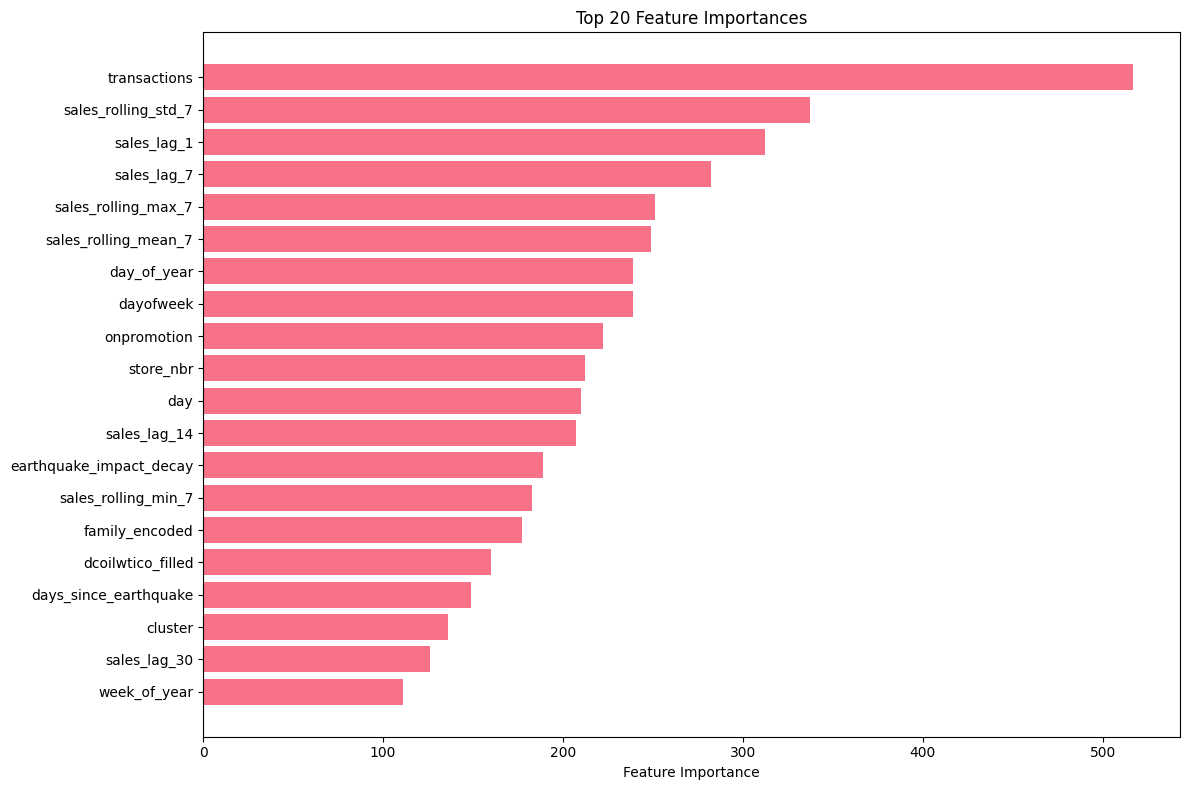

In [10]:
# Train final model on full training data
print("Training final model on full training data...")
final_model = tuned_model
final_model.fit(X_train, y_train)

# Evaluate on validation set
val_predictions = final_model.predict(X_val_split)
final_results = evaluate_model(y_val_split, val_predictions, f'Final {best_model_name}')

# Feature importance analysis
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 9. Model Validation and Diagnostics

Performing model diagnostics...


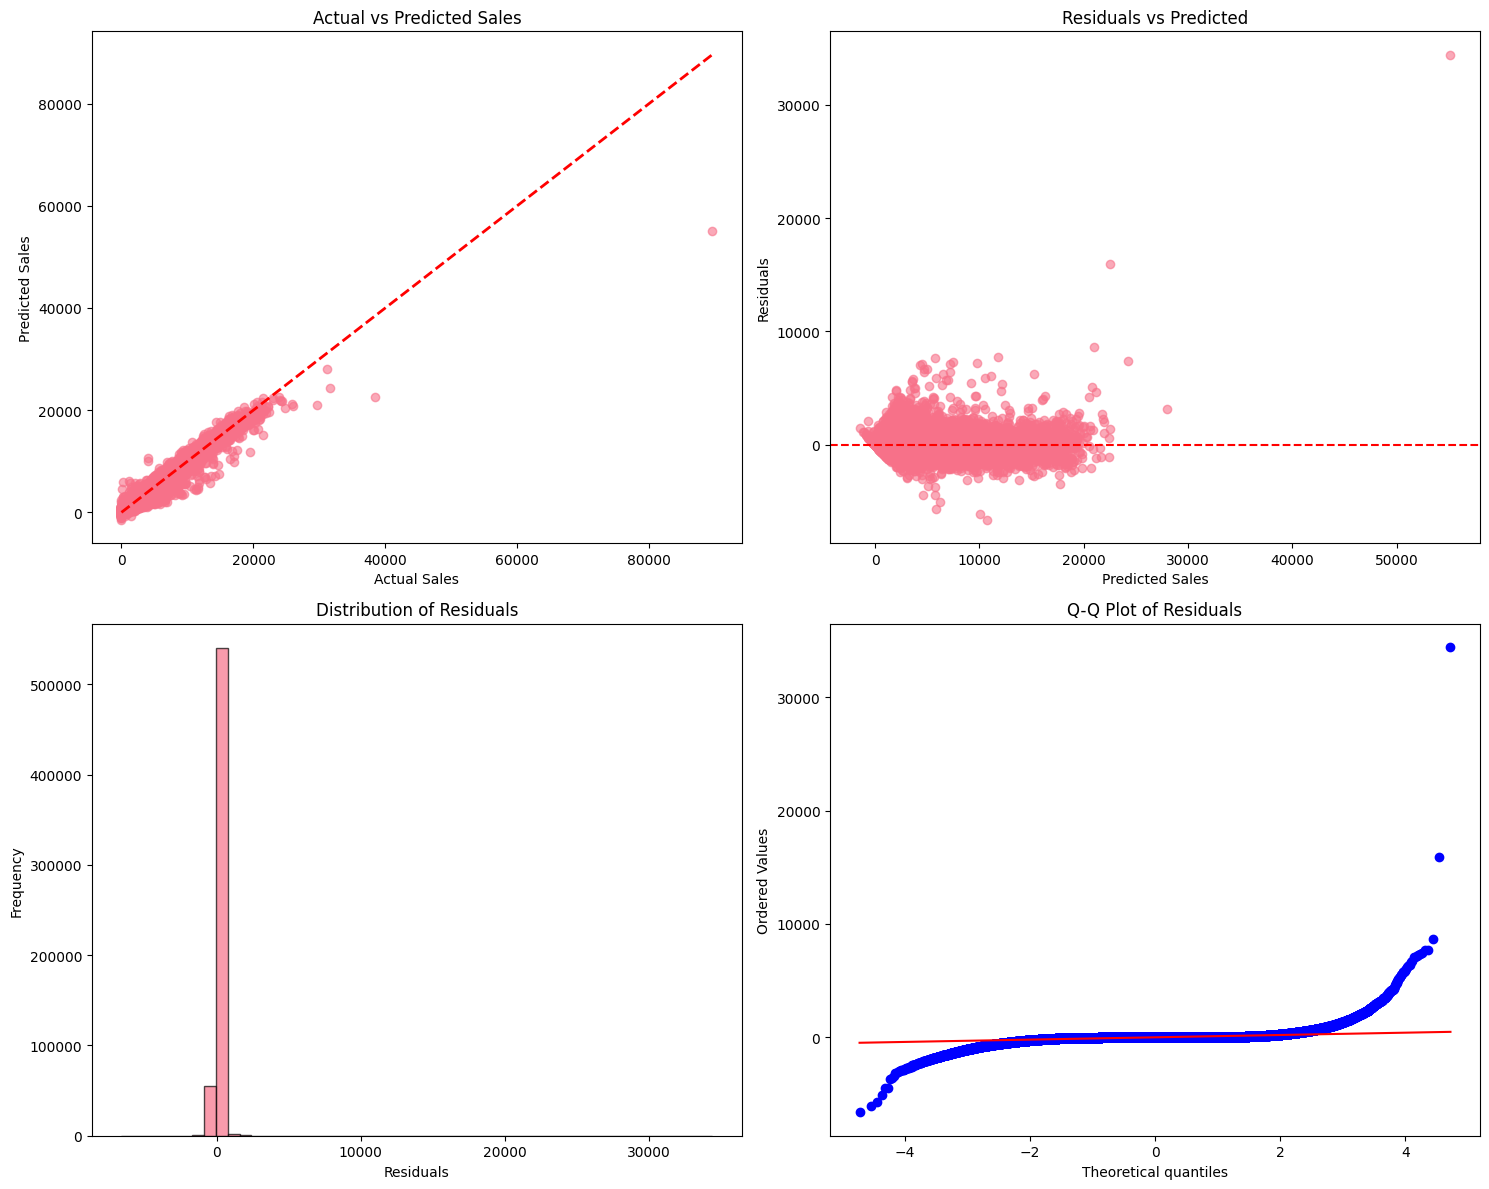


Residual Statistics:
Mean: -1.2597
Std: 166.7094
Skewness: 21.0345
Kurtosis: 3380.1613


In [11]:
# Prediction analysis
print("Performing model diagnostics...")

# Residual analysis
residuals = y_val_split - val_predictions

# Plot diagnostics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Actual vs Predicted
axes[0,0].scatter(y_val_split, val_predictions, alpha=0.6)
axes[0,0].plot([y_val_split.min(), y_val_split.max()], [y_val_split.min(), y_val_split.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Sales')
axes[0,0].set_ylabel('Predicted Sales')
axes[0,0].set_title('Actual vs Predicted Sales')

# Residuals vs Predicted
axes[0,1].scatter(val_predictions, residuals, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Sales')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals vs Predicted')

# Residuals distribution
axes[1,0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Residuals')

# Q-Q plot (approximate)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Print residual statistics
print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")
print(f"Skewness: {residuals.skew():.4f}")
print(f"Kurtosis: {residuals.kurtosis():.4f}")

## 10. Generate Predictions for Test Set

In [12]:
# Generate predictions for test set
print("Generating predictions for test set...")
test_predictions = final_model.predict(X_test)

# Ensure no negative predictions (sales can't be negative in forecasting)
test_predictions = np.maximum(test_predictions, 0)

# Create submission dataframe
submission_df = test_engineered[['id']].copy()
submission_df['sales'] = test_predictions

print(f"Test predictions summary:")
print(f"Mean: {test_predictions.mean():.2f}")
print(f"Median: {np.median(test_predictions):.2f}")
print(f"Min: {test_predictions.min():.2f}")
print(f"Max: {test_predictions.max():.2f}")

# Save predictions
submission_df.to_csv('../data/processed/test_predictions.csv', index=False)
print("\nPredictions saved to '../data/processed/test_predictions.csv'")

Generating predictions for test set...
Test predictions summary:
Mean: 19.55
Median: 10.34
Min: 0.00
Max: 337.38

Predictions saved to '../data/processed/test_predictions.csv'


## 11. Model Persistence and Summary

In [ ]:
import pickle
from datetime import datetime

# Save the final model
model_filename = f'../models/store_sales_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump({
        'model': final_model,
        'feature_columns': feature_columns,
        'label_encoders': label_encoders,
        'model_name': best_model_name,
        'performance': final_results
    }, f)

print(f"Model saved to: {model_filename}")

# Create model summary
print("\n" + "="*60)
print("📊 MODELING PIPELINE SUMMARY")
print("="*60)

print(f"\n🤖 BEST MODEL: {best_model_name}")
print(f"Final RMSE: {final_results['rmse']:.4f}")
print(f"Final MAE: {final_results['mae']:.4f}")
print(f"Final R²: {final_results['r2']:.4f}")

print(f"\n📈 DATASET INFORMATION:")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Number of features: {len(feature_columns)}")

print(f"\n🎯 FEATURE ENGINEERING:")
print("✓ Temporal features (cyclical encoding)")
print("✓ Lag features (1, 7, 14, 30 days)")
print("✓ Rolling statistics (7, 14, 30 day windows)")
print("✓ External data integration (oil prices, holidays, transactions)")
print("✓ Store and product family aggregations")
print("✓ Interaction features")

print(f"\n🔧 MODEL CONFIGURATION:")
if hasattr(final_model, 'get_params'):
    params = final_model.get_params()
    for key, value in list(params.items())[:5]:  # Show first 5 parameters
        print(f"{key}: {value}")

print(f"\n💾 OUTPUTS:")
print(f"Model file: {model_filename}")
print(f"Predictions: ../data/processed/test_predictions.csv")

print("\n" + "="*60)
print("🚀 MODELING PIPELINE COMPLETE!")
print("="*60)

## 4.5. Domain-Specific Feature Analysis

Let's analyze the impact of our new payroll cycle and earthquake features to validate their effectiveness.

In [ ]:
def analyze_payroll_impact(df):
    """Analyze the impact of payroll cycles on sales"""
    print("=== PAYROLL CYCLE IMPACT ANALYSIS ===")
    
    # Sales by payday status
    payday_analysis = df.groupby('is_payday')['sales'].agg(['mean', 'median', 'count']).round(2)
    payday_analysis.index = ['Non-Payday', 'Payday']
    print("\nSales by Payday Status:")
    print(payday_analysis)
    
    # Calculate payday effect
    payday_effect = payday_analysis.loc['Payday', 'mean'] / payday_analysis.loc['Non-Payday', 'mean']
    print(f"\nPayday Effect: {payday_effect:.3f}x higher average sales on paydays")
    
    # Near payday analysis
    near_payday_analysis = df.groupby('is_near_payday')['sales'].agg(['mean', 'median']).round(2)
    near_payday_analysis.index = ['Far from Payday', 'Near Payday']
    print("\nSales by Payday Proximity:")
    print(near_payday_analysis)
    
    # Payday proximity effect by day
    proximity_effect = df.groupby('payday_proximity')['sales'].mean().round(2)
    print("\nSales by Days from Payday:")
    print(proximity_effect.head(10))
    
    # Promotion effectiveness during paydays
    promo_payday = df.groupby(['is_payday', 'onpromotion'])['sales'].mean().round(2)
    print("\nPromotion Effectiveness by Payday Status:")
    print(promo_payday)
    
    # Product family differences during paydays
    if 'is_essential_family' in df.columns:
        family_payday = df.groupby(['is_payday', 'is_essential_family'])['sales'].mean().round(2)
        print("\nEssential vs Non-Essential Sales on Paydays:")
        print(family_payday)
    
    return payday_effect

def analyze_earthquake_impact(df):
    """Analyze the impact of the 2016 earthquake on sales"""
    print("\n=== EARTHQUAKE IMPACT ANALYSIS ===")
    
    # Filter data around earthquake period
    earthquake_date = pd.to_datetime('2016-04-16')
    earthquake_period = df[(df['date'] >= earthquake_date - timedelta(days=30)) & 
                          (df['date'] <= earthquake_date + timedelta(days=90))].copy()
    
    if len(earthquake_period) > 0:
        # Sales during different earthquake phases
        earthquake_phases = earthquake_period.groupby([
            'earthquake_immediate', 'earthquake_recovery', 'earthquake_normalization'
        ])['sales'].agg(['mean', 'count']).round(2)
        
        print("\nSales During Earthquake Phases:")
        phase_names = ['Normal', 'Immediate (Week 1)', 'Recovery (Weeks 2-4)', 'Normalization (Months 2-3)']
        for i, (idx, row) in enumerate(earthquake_phases.iterrows()):
            if any(idx):  # If any phase indicator is True
                phase_name = phase_names[list(idx).index(1) + 1]
                print(f"{phase_name}: Mean={row['mean']:.2f}, Count={row['count']}")
        
        # Pre vs post earthquake comparison
        pre_earthquake = df[df['date'] < earthquake_date]['sales'].mean()
        post_earthquake_week1 = earthquake_period[earthquake_period['earthquake_immediate'] == 1]['sales'].mean()
        post_earthquake_month1 = earthquake_period[earthquake_period['is_earthquake_month'] == 1]['sales'].mean()
        
        print(f"\nEarthquake Impact Comparison:")
        print(f"Pre-earthquake average: {pre_earthquake:.2f}")
        print(f"Week 1 post-earthquake: {post_earthquake_week1:.2f} ({(post_earthquake_week1/pre_earthquake-1)*100:.1f}% change)")
        print(f"Month 1 post-earthquake: {post_earthquake_month1:.2f} ({(post_earthquake_month1/pre_earthquake-1)*100:.1f}% change)")
        
        # Essential vs non-essential during earthquake
        if 'is_essential_family' in earthquake_period.columns:
            essential_earthquake = earthquake_period.groupby([
                'earthquake_immediate', 'is_essential_family'
            ])['sales'].mean().round(2)
            print("\nEssential vs Non-Essential During Immediate Earthquake Period:")
            print(essential_earthquake)
    else:
        print("No earthquake period data available in the dataset")

def visualize_domain_features(df):
    """Create visualizations for domain-specific features"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Sales by day relative to payday
    payday_cycle = df.groupby('days_since_payday')['sales'].mean()
    axes[0,0].plot(payday_cycle.index, payday_cycle.values, marker='o')
    axes[0,0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Payday')
    axes[0,0].axvline(x=15, color='red', linestyle='--', alpha=0.7)
    axes[0,0].set_xlabel('Days Since Last Payday')
    axes[0,0].set_ylabel('Average Sales')
    axes[0,0].set_title('Sales Pattern Relative to Payday Cycle')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Payday proximity effect
    proximity_sales = df.groupby('payday_proximity')['sales'].mean()
    axes[0,1].bar(proximity_sales.index, proximity_sales.values, alpha=0.7)
    axes[0,1].set_xlabel('Days to Nearest Payday')
    axes[0,1].set_ylabel('Average Sales')
    axes[0,1].set_title('Sales by Proximity to Payday')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Promotion effectiveness during paydays
    promo_payday_data = df.groupby(['is_near_payday', 'onpromotion'])['sales'].mean().unstack()
    promo_payday_data.plot(kind='bar', ax=axes[0,2], alpha=0.7)
    axes[0,2].set_xlabel('Near Payday')
    axes[0,2].set_ylabel('Average Sales')
    axes[0,2].set_title('Promotion Effectiveness: Payday vs Non-Payday')
    axes[0,2].legend(['No Promotion', 'On Promotion'])
    axes[0,2].tick_params(axis='x', rotation=0)
    
    # 4. Earthquake impact over time
    earthquake_date = pd.to_datetime('2016-04-16')
    earthquake_window = df[(df['date'] >= earthquake_date - timedelta(days=60)) & 
                          (df['date'] <= earthquake_date + timedelta(days=120))].copy()
    
    if len(earthquake_window) > 0:
        daily_sales_earthquake = earthquake_window.groupby('date')['sales'].mean()
        axes[1,0].plot(daily_sales_earthquake.index, daily_sales_earthquake.values, alpha=0.7)
        axes[1,0].axvline(x=earthquake_date, color='red', linestyle='--', linewidth=2, label='Earthquake')
        axes[1,0].set_xlabel('Date')
        axes[1,0].set_ylabel('Average Daily Sales')
        axes[1,0].set_title('Sales Around Earthquake Period')
        axes[1,0].legend()
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # 5. Essential vs Non-essential during paydays
    if 'is_essential_family' in df.columns:
        family_payday_data = df.groupby(['is_payday', 'is_essential_family'])['sales'].mean().unstack()
        family_payday_data.plot(kind='bar', ax=axes[1,1], alpha=0.7)
        axes[1,1].set_xlabel('Payday')
        axes[1,1].set_ylabel('Average Sales')
        axes[1,1].set_title('Essential vs Non-Essential Sales on Paydays')
        axes[1,1].legend(['Essential', 'Non-Essential'])
        axes[1,1].tick_params(axis='x', rotation=0)
    
    # 6. Feature correlation heatmap
    domain_features = [
        'is_payday', 'is_near_payday', 'payday_proximity', 'days_since_payday',
        'earthquake_immediate', 'earthquake_recovery', 'earthquake_impact_decay',
        'onpromotion', 'is_weekend', 'sales'
    ]
    available_features = [f for f in domain_features if f in df.columns]
    corr_matrix = df[available_features].corr()
    
    im = axes[1,2].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[1,2].set_xticks(range(len(available_features)))
    axes[1,2].set_yticks(range(len(available_features)))
    axes[1,2].set_xticklabels(available_features, rotation=45, ha='right')
    axes[1,2].set_yticklabels(available_features)
    axes[1,2].set_title('Feature Correlation Matrix')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[1,2], shrink=0.8)
    
    plt.tight_layout()
    plt.show()

# Apply domain-specific feature analysis after feature engineering
print("Analyzing domain-specific features...")
payday_effect = analyze_payroll_impact(train_engineered)
analyze_earthquake_impact(train_engineered)
visualize_domain_features(train_engineered.sample(n=min(50000, len(train_engineered)), random_state=42))